# 전이학습(Transfer Learning)

전이학습을 통하여 이미지 분류를 위한 합성곱 신경망을 어떻게 학습할 지.

실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에, (무작위 초기화를 통해) 맨 처음부터 합성곱 신경망 전체를 학습하는 사람은 매우 적다.

대신 매우 큰 데이터셋에서 합성곱 신경망을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업을 위한 초기 설정 또는 고정된 특징 추출기로 사용합니다

이러한 전이학습 시나리오의 주요한 2가지는 다음과 같다.

* 합성곱 신경망의 미세 조정(Finetuning)
    * 무작위 초기화 대신, 신경망을 ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화한다. 학습의 나머지 과정들은 평상시와 동일하다.
* 고정된 특징 추출기로써의 합성곱 신경망
    * 여기서는 마지막에 완전히 연결된 계층을 제외한 모든 신경망의 가중치를 고정한다.
    * 이 마지막의 완전히 연결된 계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습한다.



In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

# 데이터 불러오기

데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용한다.

여기서 풀고자 하는 문제는 개미와 벌을 분류하는 모델을 학습하는 것입니다. 개미와 벌 각각의 학습용 이미지는 대략 120장 정도있고, 75개의 검증용 이미지가 있습니다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기엔 아주 작은 데이터셋입니다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을 것입니다.

In [9]:
# 학습을 위한 데이터 증가(augmentation)) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])      
}

data_dir = 'hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']
}
dataloader = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']
}

dataset_size = {
    x: len(image_datasets[x]) for x in ['train', 'val']
}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 일부 이미지 시각화 하기

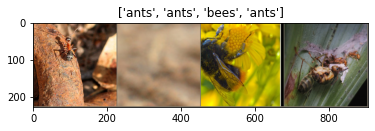

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloader['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# 모델 학습하기

이제 모델을 학습하기 위한 일반 함수를 작성한다. 

In [16]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-'*15)

        # 각 epoch는 학습 단계와 검증 단계를 갖습니다.

        for phase in ['train', 'val']:
            if phase == 'train': model.train()
            else: model.eval()
        
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloader[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            # 순전파
            # 학습 시에만 연산 기록을 추적
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 학습 단계인 경우 역전파 + 최적화
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
            scheduler.step()
        
        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()